In [11]:
from plugins.read_data_from_postgres import load_data_from_postgres
import psycopg2
import numpy as np

In [3]:
from plugins.read_data_from_postgres import load_data_from_postgres

database = "postgres"
user = "postgres"
password = "javamylife"
host = "database-3.c5go4e6kame4.us-east-1.rds.amazonaws.com"
port = 5432
table = "electric_vehicles"

df = load_data_from_postgres(database, user, password, host, port, table)

In [4]:
df.head()

,id,date,county_id,vehicle_primary_use_id,bev,phev,ev_total,non_ev_total,total_vehicles,percent_ev
0,1401,2019-06-30,579,6,0,0,0,8586,8586,0.00
1,1402,2023-04-30,799,6,8,0,8,28276,28284,0.03
2,1403,2019-08-31,727,6,0,0,0,21265,21265,0.00
3,1404,2019-05-31,668,5,1,0,1,209,210,0.48
4,1405,2021-01-31,497,5,0,1,1,14,15,6.67


In [5]:
# Count occurrences of vehicle_primary_use_id equal to 5
count_5 = df[df['vehicle_primary_use_id'] == 5].shape[0]

# Count occurrences of vehicle_primary_use_id equal to 6
count_6 = df[df['vehicle_primary_use_id'] == 6].shape[0]

print("Count of vehicle_primary_use_id equal to 5:", count_5)
print("Count of vehicle_primary_use_id equal to 6:", count_6)

Count of vehicle_primary_use_id equal to 5: 17010
Count of vehicle_primary_use_id equal to 6: 3398


In [6]:
from sklearn.utils import resample
import pandas as pd


majority_class = df[df['vehicle_primary_use_id'] == 5]
minority_class = df[df['vehicle_primary_use_id'] == 6]

# Down sample majority class to match minority class
downsampled_majority = resample(majority_class, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(minority_class),  # to match minority class
                                 random_state=42)  # reproducible results

# Combine minority class with down sampled majority class
balanced_df = pd.concat([downsampled_majority, minority_class])

In [7]:
balanced_df.head()

,id,date,county_id,vehicle_primary_use_id,bev,phev,ev_total,non_ev_total,total_vehicles,percent_ev
5826,7227,2021-01-31,644,5,1,1,2,102,104,1.92
4652,6053,2022-09-30,491,5,377,210,587,166427,167014,0.35
867,2268,2020-01-31,456,5,7,7,14,12908,12922,0.11
15134,16535,2019-12-31,643,5,0,5,5,668,673,0.74
6613,8014,2017-01-31,558,5,6,21,27,31524,31551,0.09


In [8]:
# Count occurrences of vehicle_primary_use_id equal to 5
count_5 = balanced_df[balanced_df['vehicle_primary_use_id'] == 5].shape[0]

# Count occurrences of vehicle_primary_use_id equal to 6
count_6 = balanced_df[balanced_df['vehicle_primary_use_id'] == 6].shape[0]

print("Count of vehicle_primary_use_id equal to 5:", count_5)
print("Count of vehicle_primary_use_id equal to 6:", count_6)

Count of vehicle_primary_use_id equal to 5: 3398
Count of vehicle_primary_use_id equal to 6: 3398


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


# Split the data into features (X) and target variable (y)
X = balanced_df.drop(['id', 'vehicle_primary_use_id', 'date'], axis=1)  # Assuming 'id' and 'date' are not features
y = balanced_df['vehicle_primary_use_id']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5) 

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

              precision    recall  f1-score   support

           5       1.00      0.96      0.98       700
           6       0.95      1.00      0.97       660

    accuracy                           0.97      1360
   macro avg       0.98      0.98      0.97      1360
weighted avg       0.98      0.97      0.98      1360

Accuracy: 0.975
Mean Squared Error (MSE): 0.025
Root Mean Squared Error (RMSE): 0.15811388300841897


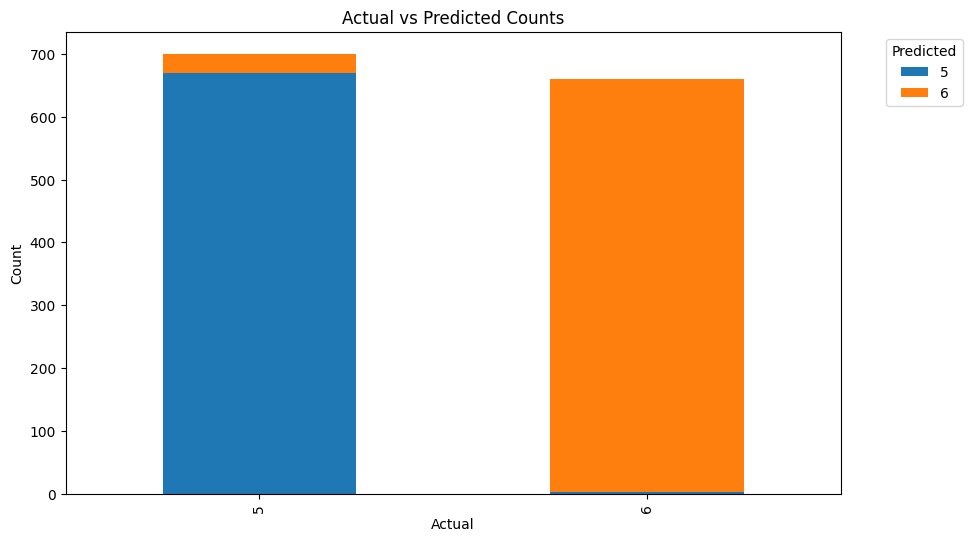

In [14]:
from matplotlib import pyplot as plt

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
counts_df = predictions_df.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

# Plot bar plot
counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Actual')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts')
plt.legend(title='Predicted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

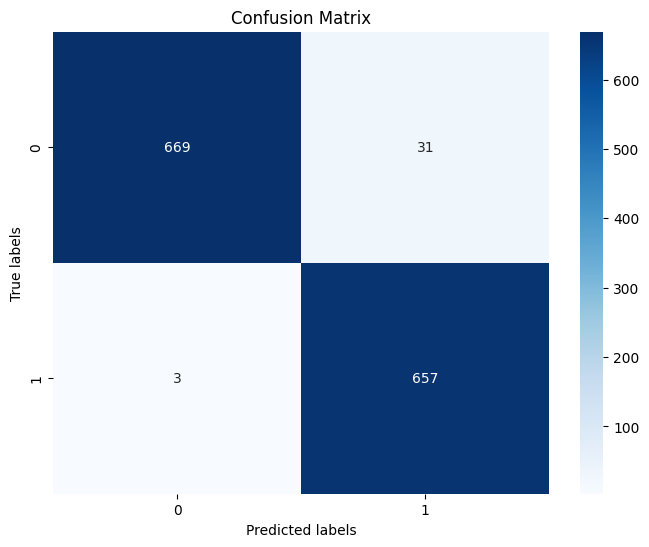

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()